In [1]:
using JuMP, Gurobi, Random

In [2]:
using JuMP, Gurobi, StatsBase, DataFrames, CSV, LinearAlgebra, Distributions, Random
const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2022-07-20


Gurobi.Env(Ptr{Nothing} @0x00007fb4ee1b9600, false, 0)

In [57]:
#using Dualization

┌ Info: Precompiling Dualization [191a621a-6537-11e9-281d-650236a99e60]
└ @ Base loading.jl:1278


In [12]:
function l2_regression(X, y, rho; solver_output=0)
    n,p = size(X)
    
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", solver_output) 
    
    @variable(model,beta[j=1:p])
    @variable(model, sse>=0)
    @variable(model, reg>=0)
    @constraint(model, sum((y[i]-sum(X[i,j]*beta[j] for j=1:p))^2 for i=1:n) <= sse)
    @constraint(model, sum(beta[j]^2 for j=1:p)<=reg)
    @objective(model,Min, 1/n*sse + rho*reg)
    
    optimize!(model)
    println("Obj ", objective_value(model))
    return (value.(beta))
end

l2_regression (generic function with 1 method)

In [3]:
function solve_model(m)
    optimize!(m)
    U_OA = objective_value(m)
    println("U_OA from solve ", U_OA)
    return value.(m[:y]), U_OA
end

solve_model (generic function with 1 method)

In [4]:
function solve_model_benders(m)
    "Solve the Benders master problem
    "
    optimize!(m)
    U_OA = objective_value(m)
    #println("U_OA from solve ", U_OA)
    return value.(m[:β]), value.(m[:α]), U_OA
end

solve_model_benders (generic function with 1 method)

In [5]:
function get_Y(X, t)
    "
    Create the vector of data for the dual problem
    "
    T, p = size(X)
    Y = zeros(1,T*p)
    Y[(t-1)*p+1:t*p] = X[t,:]
    return Y
end

function get_Z(X)
    T, p = size(X)
    Z = zeros(T, T*p)
    for t=1:T
        Z[t,:] = get_Y(X,t)
    end
    return Z
end

function get_A(X, t)
    T, p = size(X)
    A = zeros(p,T*p)
    A[:,(t-1)*p+1:t*p] = 1 * Matrix(I, p, p)
    return A
end

get_A (generic function with 1 method)

In [84]:
function S_primal(X, y, β0, epsilon, delta)
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus[i=1:n],  - y[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus[i=1:n],  y[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return objective_value(model), getvalue.(β)
end

S_primal (generic function with 1 method)

In [115]:
function master_primal(X0, Xt, y0, Dmin, Dmax, epsilon, delta, reg, ρ)
    
    n0, p = size(X0)
    n, _ = size(Xt)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 
    @variable(model, β0[j=1:p])
    # Add objective
    @objective(model, Min, 1/n0*sum((y0[i]-sum(X0[i,j]*β0[j] for j=1:p))^2 for i=1:n0) 
        + reg*sum(b[i] for i=1:n) + ρ*sum(β0[j]^2 for j=1:p))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus_min[i=1:n],  - Dmin[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus_min[i=1:n],  Dmin[i] - dot(X[i,:],β[i,:]) <= b[i])
    
    @constraint(model, res_plus_max[i=1:n],  - Dmax[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus_max[i=1:n],  Dmax[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return objective_value(model), getvalue.(β), getvalue.(β0)
end

master_primal (generic function with 2 methods)

In [6]:
function S_dual(X, y, β0, epsilon, delta)
    
    #Dual problem
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return objective_value(model), getvalue.(λ), getvalue.(ν), getvalue.(μ)
end

S_dual (generic function with 1 method)

In [7]:
function R(X, D_min, D_max, β0, epsilon, delta) 
    "
    Full dual problem
    "
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
       
    # Add objective
    @objective(model, Max, 2*dot(λ[1,:],y) - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T)) #
    optimize!(model)
    return objective_value(model), getvalue.(y), getvalue.(λ), getvalue.(ν), getvalue.(μ)
end

R (generic function with 1 method)

In [201]:
function master_problem(X0, Xt, y0, D_min, D_max, threshold = 0.1, epsilon = 0.1, delta = 0.1, reg = 1, ρ = 1, max_cuts = 10, verbose=0)
    n, p = size(X0)
    T, p = size(Xt)
    #Z = get_Z(X0)
    L_BD = -10000
    U_BD = 10000
    cuts = 0
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, α)
    @variable(model, β[j=1:p])
    
    #Warm start for β
    β_val0 = l2_regression(X0, y0, ρ)#Random.rand(p)#
    
    #Initialization
    _, y_val0, λ_val0, ν_val0, μ_val0 = R(Xt, D_min, D_max, β_val0, epsilon, delta)
    
    #First constraint
    @constraint(model, α >= 2*dot(λ_val0[1,:],y_val0) - sum(y_val0)
                            - delta * sum(sum(ν_val0[1,t,i]+ν_val0[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val0[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val0[2,t,:]) for t = 1:T))
       
    # Add objective
    @objective(model, Min, 1/n*sum((y0[i]-sum(X0[i,j]*β[j] for j=1:p))^2 for i=1:n) + reg*α + ρ*sum(β[j]^2 for j=1:p))
    
    while cuts < max_cuts && U_BD - L_BD > threshold
        if verbose
            println("Lower: ", L_BD, " Upper: ", U_BD)
        end
        cuts += 1
        
        #Solve current Master Problem
        β_val, α_val, L_BD = solve_model_benders(model)
        U_OA, y_val, λ_val, ν_val, μ_val = R(Xt, D_min, D_max, β_val, epsilon, delta)
        
        U_BD = 1/n*sum((y0[i]-sum(X0[i,j]*β_val[j] for j=1:p))^2 for i=1:n) + reg*U_OA + ρ*sum(β_val[j]^2 for j=1:p)
        
        if U_BD - L_BD > threshold
            @constraint(model, α >= 2*dot(λ_val[1,:],y_val) - sum(y_val)
                            - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val[2,t,:]) for t = 1:T))
            if verbose                    
                println("Cut added")
                println("y_val: ", y_val)
            end
        end
    end
    optimize!(model)
    β_val, α_val, L_BD = solve_model_benders(model)
    U_OA, y_val, λ_val, ν_val, μ_val = R(Xt, D_min, D_max, β_val, epsilon, delta)
    if verbose
        println("Final model Obj value: ", objective_value(model))
        println("Lower: ", L_BD, " Upper: ", U_BD)
        println("Final y: ", y_val)
    end
    return objective_value(model), getvalue.(β), getvalue.(α), y_val#, getvalue.(ν), getvalue.(μ)
end    

master_problem (generic function with 8 methods)

In [120]:
X_test_adaptive = CSV.read("traffic_predictions_test_val.csv", DataFrame)
select!(X_test_adaptive, Not([:DummyRegressor,:Lasso, :LassoLars]))#, index = 'Unnamed: 0')
y_test = CSV.read("traffic_test_val_scaled.csv", DataFrame)#, index = 'Unnamed: 0')
n0 = 1000
n = 100
m = 1
X = X_test_adaptive[!,1:25]
y = y_test[!, "target"];
X0 = Matrix(X[n0:n0+n,:])
X0[:,1] = ones(n+1)
y0 = y[n0:n0+n,:][:]

yt_true = y[n0+n+1:n0+n+m,:][:]
Xt = Matrix(X[n0+n+1:n0+n+m,:])
Xt[:,1] = ones(m)
yt = mean(Xt, dims = 2)#y[n0+n+1:n0+n+m,:][:]
epsilon = 0.01
delta = 0.01
threshold = 1e-8
reg = 1;

#X_test_adaptive = X_test_adaptive.drop(columns = ['DummyRegressor', 'Lasso', 'LassoLars'])

In [145]:
function prepare_data_from_X(X, y, n0, n, m, std_factor)
    
    X0 = Matrix(X[n0:n0+n,:])
    X0[:,1] = ones(n+1)
    y0 = y[n0:n0+n,:][:]

    yt_true = y[n0+n+1:n0+n+m,:][:]
    Xt = Matrix(X[n0+n+1:n0+n+m,:])
    Xt[:,1] = ones(m)
    yt = mean(Xt, dims = 2)
    
    D_min = yt .- std_factor*std(Xt, dims = 2)
    D_max = yt .+ std_factor*std(Xt, dims = 2)
    
    return X0, y0, Xt, yt, yt_true, D_min, D_max
end

prepare_data_from_X (generic function with 1 method)

In [168]:
function prepare_data_from_y(X, y, n0, n, m, uncertainty, last_yT = false)
    
    X0 = Matrix(X[n0:n0+n,:])
    X0[:,1] = ones(n+1)
    y0 = y[n0:n0+n,:][:]

    yt_true = y[n0+n+1:n0+n+m,:][:]
    Xt = Matrix(X[n0+n+1:n0+n+m,:])
    Xt[:,1] = ones(m)
    yt = yt_true
    if last_yT
        yt_true[m] = mean(Xt[m])
    end
    
    D_min = yt .- uncertainty.*abs.(yt)
    D_max = yt .+ uncertainty.*abs.(yt)
    
    return X0, y0, Xt, yt, yt_true, D_min, D_max
end

prepare_data_from_y (generic function with 2 methods)

In [97]:
function build_beta(X, y, n0, n, m, std_factor, steps)
    p = size(X)[2]
    β_list = zeros(steps, p)
    for s=1:steps
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data(X, y, n0+s, n, m, std_factor)
        obj, β, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)
        β_list[s,:] = β
    end
    return β_list
end

build_beta (generic function with 1 method)

In [214]:
function eval(X, y, split, epsilon, delta, past, reg = 1, max_cuts = 10, verbose = false, last_yT = true)
    n, p = size(X)
    split_index = floor(Int,n*split)
    val = 3#n-split_index
    β_list = zeros(val, p)
    for s=1:10 #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-4*past, 3*past, past-1, 0.001, last_yT)
        obj, β0_val, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, max_cuts, verbose)
        _, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta);
        #println("Beta.     ", size(Xt))
        β_list[s,:] = βt_val[past-1,:]
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, 0.001, last_yT)
    println("MAE :", mean(abs(yt_true[s]-dot(Xt[s,:],β_list[s,:])) for s=1:val))
    return β_list
end

eval (generic function with 7 methods)

In [215]:
β_list = eval(X, y, 0.8, 0.05, 0.05, 3, 1, 10, false, false)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.09082537931156584
Academic license - for non-commercial use only - expires 2022-07-20
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.08724668554178527
Academic license - for non-commercial use only - expires 2022-07-20
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.08488452647581426
Academic license - for non-commercial use only - expires 2022-07-20
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.08997122187633676
Academic license - for non-commercial use only - expires 2022-07-20


LoadError: [91mBoundsError: attempt to access 3×25 Array{Float64,2} at index [4, 1:25][39m

In [212]:
n,p=size(X)
val = 3
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, floor(Int,n*0.8), val, 0.01, true)
println("MAE :", mean(abs(yt_true[s]-dot(Xt[s,:],β_list[s,:])) for s=1:val))

MAE :0.9323186307897555


In [213]:
β_l2 = l2_regression(X0,y0,1);
println("MAE :", mean(abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val))

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.11111526860147564
MAE :0.15964074834050396


In [142]:
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data(X, y, 300, 400, 2, 0.)
obj, β0_val, _, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, 0.1, 1, 20, true)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.08787389193966332
Lower: -10000 Upper: 10000
Cut added
y_val: [-0.4438634407028389, -0.2669528500875359]
Lower: 0.08760871477928456 Upper: 0.09072526137029006
Final model Obj value: 0.08846030179307285
Lower: 0.08846030179307285 Upper: 0.08846030163598706
Final y: [-0.4438634407028389, -0.2669528500875359]


(0.08846030179307285, [-0.010555923435534482, 0.02357447928307372, 0.06419459584974435, 0.03681621534625416, 0.052105526397892545, 0.010547208295995852, 0.0373715649914342, 0.04918739369128185, 0.06139584506532227, 0.024117591077050138  …  0.03755464350439953, 0.03774217544111385, 0.03796950165073218, 0.04138670022060396, 0.037278475748636936, 0.03731017474469322, 0.03704146928307171, 0.0368889792709088, 0.024117591077092625, 0.05948026684979625], 6.352980433388389e-10, [-0.4438634407028389, -0.2669528500875359])

In [126]:
dot(Xt, β0_val)

-0.5391849574368471

In [128]:
D_max

1×1 Array{Float64,2}:
 -0.480331955523085

In [141]:
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_X(X, y, 300, 400, 1, 0.)
obj, βt_val, β0_val = master_primal(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, 1)

Academic license - for non-commercial use only - expires 2022-07-20


(0.0914606697632886, [-0.01605447853055833 0.048839964337049756 … 0.019304816250879667 0.04047133031571596], [-0.02605447853055833, 0.038840003747559526, 0.05046802964917312, 0.03951901122493026, 0.051472762910782004, 0.007897039311877045, 0.038434643892448876, 0.05076479206901466, 0.0523842061322568, 0.029304816250884356  …  0.038481593528194934, 0.03808749329225117, 0.036636309341023444, 0.025842802267554997, 0.03876248897304282, 0.03873338794850366, 0.039896930879418674, 0.039612406486677056, 0.029304816250879665, 0.05047133031571596])

In [139]:
obj, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta);
βt_val

Academic license - for non-commercial use only - expires 2022-07-20


1×25 Array{Float64,2}:
 -0.0160545  0.02884  0.040468  0.029519  …  0.0296124  0.0291801  0.0404713

In [140]:
i = 2
println(dot(βt_val[i,:],Xt[i,:]))
println(dot(β0_val,Xt[i,:]))
println(D_min[i])
println(D_max[i])
println(yt_true[i])

LoadError: [91mBoundsError: attempt to access 1×25 Array{Float64,2} at index [2, 1:25][39m

In [143]:
yt_true

2-element Array{Float64,1}:
 -0.6861589988354124
 -0.43445003682314165

In [78]:
β0_val

5-element Array{Float64,1}:
 0.11319981345745399
 0.1467830496468457
 0.1352065913756849
 0.16110033703301518
 0.16100067847060895

In [49]:
β_list = build_beta(X,y,1000,3,1,0.5,50)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.17678775118403384
Final model Obj value: 0.1767872974899367
Lower: 0.1767872974899367 Upper: 0.17678729748993643
Final y: [0.6826032305417639]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.13075599007301014
Final model Obj value: 0.13075585689199842
Lower: 0.13075585689199842 Upper: 0.13075585689199343
Final y: [0.744526188263374]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.12714497284627793
Final model Obj value: 0.1271446049595617
Lower: 0.1271446049595617 Upper: 0.1271446049595239
Final y: [1.0578491679073934]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.09130690729345065
Final model Obj value: 0.0913067873698079
Lower: 0.0913067873698079 Upper: 0.09130678736980788
Final y: [0.7547057491308419]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.10258651992052309
Final model Obj value: 0.102586273333196

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.06367296570953485
Final model Obj value: 0.06367281033954875
Lower: 0.06367281033954875 Upper: 0.06367281033954741
Final y: [0.6584428363579891]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.05546725363393629
Final model Obj value: 0.055467151521738534
Lower: 0.055467151521738534 Upper: 0.05546715152174092
Final y: [0.30424920788426074]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.0557881241930975
Final model Obj value: 0.05578768227391562
Lower: 0.05578768227391562 Upper: 0.05578768227392586
Final y: [0.0062057990179668066]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.03626864562703076
Final model Obj value: 0.03626844464203405
Lower: 0.03626844464203405 Upper: 0.03626844464203817
Final y: [-0.27977499947713313]
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.07072991757021195
Final model Obj value: 0.

50×25 Array{Float64,2}:
 -0.00901722   0.0128371   0.0725933  …  0.00439653  0.0283151   0.0917659
  0.0388874    0.0182138   0.0860287     0.00690201  0.009431    0.0829059
  0.0956687    0.0367704   0.101198      0.00957185  0.03065     0.103795
  0.0522433    0.0238422   0.0656542     0.0326161   0.0360279   0.0544601
  0.0429721    0.0359026   0.0663926     0.0304805   0.013401    0.0529684
  0.0353997    0.0351328   0.0680139  …  0.0305594   0.00622853  0.0536762
  0.030162     0.0342177   0.0337154     0.0344374   0.0236998   0.0331107
  0.0436805    0.0181207   0.0292767     0.0285317   0.0365182   0.0281481
  0.0442888    0.0184294   0.0300628     0.0316146   0.0387196   0.0284406
  0.0431871    0.0185898   0.0352254     0.0334934   0.0384213   0.0331581
  0.0430052    0.0205949   0.0415171  …  0.0362833   0.0354887   0.0448324
  0.0388159    0.0208901   0.0578486     0.0405223   0.0263171   0.0583788
  0.0443612    0.02239     0.0558603     0.0430831   0.0332264   0.0553488
  

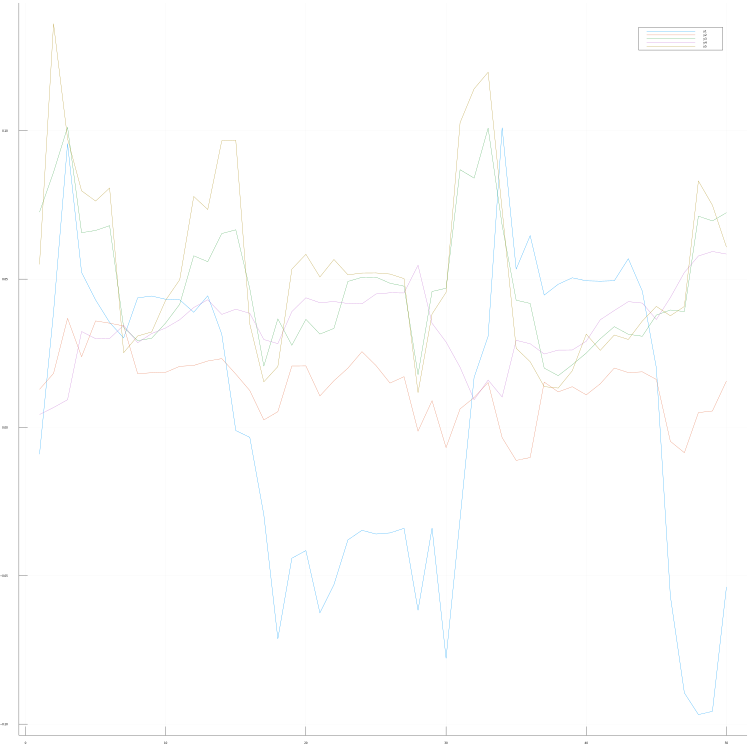

In [50]:
using Plots
plot(β_list[:,1:5])
plot!(size=(3000,3000))

# Old

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:])
                            - dot(λ_val0[2,:],y_val0) 
                            - dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            - dot(y.-y_val0,λ_val0[2,:]))
#     @constraint(model, γ >=   dot(λ_val0[2,:],y_val0) 
#                             + dot(λ[2,:].-λ_val0[2,:], y_val0) 
#                             + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α #- γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])
                                - dot(λ_val[2,:],y_val) 
                                - dot(λ[2,:].-λ_val[2,:], y_val) 
                                - dot(y.-y_val,λ_val[2,:]))
#             @constraint(model, γ >= dot(λ_val[2,:],y_val) 
#                             + dot(λ[2,:].-λ_val[2,:], y_val) 
#                             + dot(y.-y_val,λ_val[2,:]))
            println("Cut added")
        end
    end    
end

In [269]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = D_max #(D_min .+ D_max)./2
    L_OA, λ_val0, ν_val0, μ_val0 = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) + dot(λ[1,:].-λ_val0[1,:], y_val0) + dot(y.-y_val0,λ_val0[1,:]))
    
    # Add objective
    @objective(model, Max, 2*α - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
                                
            println("Cut added")
            println(y_val)
        end
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 6.89489784982016 Upper: 10000
U_OA from solve 9.50676896820302
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
[0.44910485812064715, 1.1859076466511875, 0.5476733628913486, 0.2109752836052723, 1.378041767950016, 0.374536996965517, 0.7251971752451791, 1.3691365132789919, 0.9392487930236328, 0.4227048487390981, 0.7371619945268744, 0.012081208078308148, 1.0276201350204741, 1.2833686214418156, 0.5861331896665185, 1.0650113029593455, 0.232469029952036, 1.3379676792557893, 1.4596243879928867, 1.2411937998506408]
Lower: 9.695786571685225 Upper: 9.50676896820302
U_OA from solve 9.50676896820302
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
[0.44910485812064715, 1.1859076466511875, 0.5476733628913486, 0.2109752836052723, 1.378041767950016, 0.374536996965517, 0.7251971752451791, 1.3691365132789919, 0.9392487930236328, 0.4227048487390981, 0.7371619945268744, 0.0

In [273]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = D_max #(D_min .+ D_max)./2
    L_OA, λ_val0, ν_val0, μ_val0 = S_dual(X, y_val0, β0, epsilon, delta)
    
    # Add objective
    @objective(model, Max, 2*transpose(λ[1,:])*y - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 6.139199513343522 Upper: 10000
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2850 rows, 680 columns and 4780 nonzeros
Model fingerprint: 0x505479be
Model has 30 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-04, 1e+00]
  Objective range  [5e-02, 1e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+00]
Presolve removed 2700 rows and 30 columns

Continuous model is non-convex -- solving as a MIP.

Presolve removed 2700 rows and 180 columns
Presolve time: 0.00s
Presolved: 180 rows, 530 columns, 970 nonzeros
Variable types: 500 continuous, 30 integer (30 binary)

Root relaxation: objective 1.246047e+01, 284 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

In [271]:
n = 30
p = 5
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
epsilon = 0.05
delta = 0.05

D_min = Random.rand(n)
D_max = D_min .+ 0.5 
threshold = 0.5
β0 = Random.rand(p)
model, y, L_OA, U_OA, α, γ = U(X, D_min, D_max, β0, epsilon, delta, threshold)
println(U_OA)
println(L_OA)
y

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2852 rows, 682 columns and 4883 nonzeros
Model fingerprint: 0x6bebc612
Coefficient statistics:
  Matrix range     [7e-04, 1e+00]
  Objective range  [5e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]
Presolve removed 2702 rows and 64 columns
Presolve time: 0.00s
Presolved: 150 rows, 618 columns, 1020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8856406e+01   7.312947e+01   0.000000e+00      0s
     298    1.0856114e+01   0.000000e+00   0.000000e+00      0s

Solved in 298 iterations and 0.01 seconds
Optimal objective  1.085611376e+01

User-callback calls 335, time in user-callback 0.00 sec
10000
4.960473282817949


30-element Array{Float64,1}:
 0.5191025477750704
 1.0050811033004208
 1.2099690485313632
 0.36189749029161034
 0.49893452500354263
 1.434251960631498
 1.3668963479536342
 1.2192586265507033
 0.22981764003633476
 1.3456953427792637
 1.1108493801344979
 0.33660946997334595
 0.05328918028719687
 ⋮
 0.16907880592122382
 0.1746445234450209
 0.7694805310968174
 0.8904179931067624
 1.1270924027059324
 1.3122967540717276
 1.489353226313489
 0.431520488325551
 0.19245588276446846
 1.41857722740096
 0.6543399906901304
 0.1498326677365096

In [173]:
sub_OA = U_OA - getvalue.(α)

-2.1744458297540286

In [174]:
sub_LA = L_OA - dot(λ_val[1,:],y_val) + dot(λ_val[2,:],y_val) 

-1.7376516923119785

In [ ]:
2*α - sum(y[t] for t=1:T)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T)

In [176]:
dot(λ_val[1,:],y_val) - dot(λ_val[2,:],y_val)

4.763530849986924

In [175]:
2*getvalue.(α)-sum(getvalue.(y))

4.622827386255075

In [185]:
λ_val = getvalue.(λ)

2×8 Array{Float64,2}:
 0.237489  1.0  1.0  1.0  1.0  1.0  0.0  0.5
 0.762511  0.0  0.0  0.0  0.0  0.0  1.0  0.5

In [240]:
y_val = getvalue.(y)

10-element Array{Float64,1}:
 1.246619713529564
 0.2357621500647733
 0.8031199904871795
 0.8234069949557103
 0.6149510694043452
 0.02696144751072249
 0.01934453317589746
 0.6189572592935506
 1.4168534654101108
 0.027498555784792655

In [ ]:
dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])

In [234]:
dot(λ_val0[1,:],y_val0) + dot(λ_valu[1,:].-λ_val0[1,:], y_val0) + dot(y_val.-y_val0,λ_val0[1,:])

5.322916405478342

In [235]:
dot(λ_valu[1,:],y_val) #+ dot(λ_valu[1,:].-λ_val0[1,:], y_val0) + dot(y_val.-y_val0,λ_val0[1,:])

5.322916405478343

In [243]:
#First term S
s1 = dot(λ_val[1,:],y_val)
s1

5.555131855391839

In [244]:
#Second term S
s2 = dot(λ_val[2,:],y_val)
s2

0.2783433242248072

In [242]:
#Total S
L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta);
print(L_OA)

Academic license - for non-commercial use only - expires 2022-07-20
4.1280649993127065

In [245]:
#Second part S
s3 = - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1) - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)+ sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
s3

-1.148723531854324

In [246]:
s1-s2+s3

4.128064999312707

In [247]:
getvalue.(α)

5.347249631285829

In [251]:
#First term U
u1 = 2*getvalue.(α) - sum(y_val);
u1

4.86102408295501

In [249]:
s1-s2

5.276788531167032

In [252]:
#Second term U
λ_valu, ν_valu, μ_valu = getvalue.(λ), getvalue.(ν),getvalue.(μ)
u3 = - delta * sum(sum(ν_valu[1,t,i]+ν_valu[2,t,i] for i=1:p) for t=1:T-1) - sum(dot(epsilon .+ β0, μ_valu[1,t,:]) for t = 1:T)+ sum(dot(epsilon .- β0, μ_valu[2,t,:]) for t = 1:T)
u3

-0.947176766955676

# Work in progress

In [5]:
function U(X, D_min, D_max, β0, epsilon, delta, threshold)
    
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
#         λ1_val = []
#         λ2_val = []
        
#         for t = 1:T
#             λ1_val = [λ1_val;callback_value(cb_data, λ[1,t])]
#             λ2_val = [λ2_val;callback_value(cb_data, λ[2,t])]
#         end
        
#         #linearization of the bilinear term
#         con1 = @build_constraint(α <= dot(λ1_val,y_val) 
#                                 + dot(λ[1,:].-λ1_val, y_val) 
#                                 + dot(y.-y_val,λ1_val))
#         con2 = @build_constraint(γ <= dot(λ2_val,y_val) 
#                             + dot(λ[2,:].-λ2_val, y_val) 
#                             + dot(y.-y_val,λ2_val))
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    #MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    #MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    
    optimize!(model)
    
    return model, getvalue.(y), L_OA, U_OA, getvalue.(α), getvalue.(γ)#get_objective_value(model)
end

U (generic function with 1 method)

In [455]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
#         λ1_val = []
#         λ2_val = []
        
#         for t = 1:T
#             λ1_val = [λ1_val;callback_value(cb_data, λ[1,t])]
#             λ2_val = [λ2_val;callback_value(cb_data, λ[2,t])]
#         end
        
#         #linearization of the bilinear term
#         con1 = @build_constraint(α <= dot(λ1_val,y_val) 
#                                 + dot(λ[1,:].-λ1_val, y_val) 
#                                 + dot(y.-y_val,λ1_val))
#         con2 = @build_constraint(γ <= dot(λ2_val,y_val) 
#                             + dot(λ[2,:].-λ2_val, y_val) 
#                             + dot(y.-y_val,λ2_val))
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    #MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    optimize!(model)
end

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 332 rows, 146 columns and 663 nonzeros
Model fingerprint: 0xe232e15b
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 300 rows and 10 columns
Presolve time: 0.00s
Presolved: 32 rows, 136 columns, 233 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      53    4.3074467e+00   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds
Optimal objective  4.307446677e+00

User-callback calls 90, time in user-callback 0.00 sec


In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    #MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    optimize!(model)
end

In [70]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, - γ >=   dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α + γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, "Upper: ", U_OA)
        cuts += 1
        U_OA = objective_value(model)
        y_val = getvalue.(y)
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        println(getvalue.(α))        
        if true#U_OA - L_OA > threshold
            con_α = @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
            con_γ = @constraint(model, γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
            #MOI.submit(model, con_α)
            #MOI.submit(model, con_γ)
            #model.AddConstr(con_α)
            optimize!(model)
            print("Cut added")
        end
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 1.656032211193675Upper: 10000
Academic license - for non-commercial use only - expires 2022-07-20
5.668960605208838
Cut addedLower: 2.9423204539327297Upper: 2.906032211193675
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut addedLower: 2.9423204539327297Upper: 1.8408987123197835
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut addedLower: 2.9423204539327297Upper: 1.8408987123197835
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut addedLower: 2.9423204539327297Upper: 1.8408987123197835
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut added

In [71]:
value.(model[:y])

6-element Array{Float64,1}:
 1.4095112245622
 1.395134791009657
 1.2809258382983861
 0.4408212846874644
 1.3979214012044536
 0.3709347002682817

In [160]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:])
                            - dot(λ_val0[2,:],y_val0) 
                            - dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            - dot(y.-y_val0,λ_val0[2,:]))
#     @constraint(model, γ >=   dot(λ_val0[2,:],y_val0) 
#                             + dot(λ[2,:].-λ_val0[2,:], y_val0) 
#                             + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α #- γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])
                                - dot(λ_val[2,:],y_val) 
                                - dot(λ[2,:].-λ_val[2,:], y_val) 
                                - dot(y.-y_val,λ_val[2,:]))
#             @constraint(model, γ >= dot(λ_val[2,:],y_val) 
#                             + dot(λ[2,:].-λ_val[2,:], y_val) 
#                             + dot(y.-y_val,λ_val[2,:]))
            println("Cut added")
        end
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 1.2905030686633057 Upper: 10000
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added


In [125]:
println(getvalue.(α)) ; getvalue(γ)

25.492387674355754


0.7306773571456898

In [164]:
y_val = getvalue.(y)

8-element Array{Float64,1}:
 0.5370083401843655
 1.2222521761339815
 1.339211649779766
 0.9142199248949394
 0.6387110336100499
 0.813759189123922
 0.0233854259379922
 0.08103364164996285

In [165]:
L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

Academic license - for non-commercial use only - expires 2022-07-20


(3.0258791576749458, [0.4439449525615276 1.0 … 0.0 0.0; 0.5560550474384724 0.0 … 1.0 1.0], [0.10704170581798711 0.0 … 0.0 0.0; 0.0 0.0 … 0.3461152048895899 0.20928184760755908]

[0.09499670528033732 0.0 … 0.0 0.0; 0.0 0.0774763673396135 … 1.198173288998391 0.3498816501822435]

[0.030590214594401297 0.0 … 0.0 0.0; 0.0 0.0 … 0.6745245750243316 0.5476464646076851]

[0.024632607895257577 0.0 … 0.0 0.0; 0.0 0.0 … 0.02136431484675283 0.0], [0.0 0.6421681673183743 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.6640722345242436 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.2539117436462669 … 0.0 0.0; 0.0 0.0 … 0.0 0.5668058722576801])

In [166]:
L_OA

3.0258791576749458

In [84]:
function solve_model(m)
    optimize!(m)
    U_OA = objective_value(m)
    println("U_OA from solve ", U_OA)
    return value.(m[:y]), U_OA
end

solve_model (generic function with 1 method)

In [153]:
model

A JuMP Model
Maximization problem with:
Variables: 145
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 96 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 134 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 136 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: y, α, λ, μ, ν

In [57]:
getvalue.(γ)

0.6262886348216052

In [156]:
optimize!(model)

In [157]:
objective_value(model)

2.9217585540309985

In [151]:
n = 8
p = 4
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
epsilon = 0.05
delta = 0.05

D_min = Random.rand(n)
D_max = D_min .+ 0.5 
threshold = 0.5
β0 = Random.rand(p)
model, y, L_OA, U_OA, α, γ = U(X, D_min, D_max, β0, epsilon, delta, threshold)
println(U_OA)
println(L_OA)
y

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 226 rows, 146 columns and 524 nonzeros
Model fingerprint: 0x76c0d6a2
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 4e+00]
Presolve removed 194 rows and 22 columns
Presolve time: 0.00s
Presolved: 32 rows, 124 columns, 192 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0784618e+29   8.000000e+30   1.078462e-01      0s
      72    2.9217586e+00   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.00 seconds
Optimal objective  2.921758554e+00

User-callback calls 113, time in user-callback 0.00 sec
10000
1.2905030686633057


8-element Array{Float64,1}:
 0.5370083401843655
 1.2222521761339815
 1.339211649779766
 0.9142199248949394
 0.6387110336100499
 0.813759189123922
 0.0233854259379922
 0.08103364164996285

In [17]:
function inner_primal_infinity1(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))

    # Add variables
    @variable(model, a[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    @constraint(model,[i=1:n],- y[i] + dot(X[i,:],a[i,:]) <= b[i])
    @constraint(model,[i=1:n],  y[i] - dot(X[i,:],a[i,:]) <= b[i])

    @constraint(model,[i=2:n],   a[i,:] .- a[i-1,:] .<= delta)
    @constraint(model,[i=2:n], - a[i,:] .+ a[i-1,:] .<= delta)
    
    @constraint(model,[i=1:n],   a[i,:] .- β0 .<= epsilon)
    @constraint(model,[i=1:n], - a[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(a)
end

inner_primal_infinity1 (generic function with 1 method)

# Old

In [20]:
function inner_primal_infinity2(X, y, β0, epsilon, delta)
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus[i=1:n],  - y[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus[i=1:n],  y[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(β)
end

inner_primal_infinity2 (generic function with 1 method)

In [81]:
function inner_dual_infinity_shuvo(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .<= 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return model
end

inner_dual_infinity_shuvo (generic function with 1 method)

In [109]:
function inner_dual_infinity_shuvo2(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .<= 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return model
end

inner_dual_infinity_shuvo2 (generic function with 1 method)

In [21]:
m, beta = inner_primal_infinity2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

m, beta = inner_primal_infinity_2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

model = inner_dual_infinity_shuvo2(X,y,beta_0,epsilon,delta)
print("Obj value Dual:", objective_value(model))

Academic license - for non-commercial use only - expires 2022-07-20
Obj value Primal:15.55504361195763

LoadError: [91mUndefVarError: inner_primal_infinity_2 not defined[39m

In [15]:
n = 30
p = 6
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
beta_0 = Random.rand(p)
beta_0[1] = - 0.3
epsilon = 0.1
delta = 0.1
#beta = inner_dual_infinity_leo_original_signs(X,y,beta_0,epsilon,delta)
#beta = inner_dual_infinity_leo(X,y,beta_0,epsilon,delta)



#model = inner_dual_infinity_leo(X,y,beta_0,epsilon,delta)
#print("Obj value Dual Leo:", objective_value(model))



#print("Primal 1", value(m.obj))

0.1

In [22]:
m, beta = inner_primal_infinity1(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

m, beta = inner_primal_infinity2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

m, beta = inner_primal_infinity3(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 768 rows, 210 columns and 1476 nonzeros
Model fingerprint: 0x3477086f
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+00]
Presolve removed 586 rows and 26 columns
Presolve time: 0.00s
Presolved: 182 rows, 358 columns, 578 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5099457e+01   4.523467e+00   0.000000e+00      0s
      35    1.5555044e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds
Optimal objective  1.555504361e+01

User-callback calls 64, time in user-callback 0.00 sec
Obj value Primal:15.55504361195763Academic license - for non-commercial use only - expires 2022-07-20
Obj value 

In [17]:
Z = get_Z(X)
λ = Random.rand(n)

LoadError: [91mArgumentError: indexed assignment with a single value to many locations is not supported; perhaps use broadcasting `.=` instead?[39m

In [313]:
function inner_dual_infinity_leo(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2,j=1:T]>=0) 
    @variable(model, ν[i=1:2, j=1:T,k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T,k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t=1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t=1:T)
        )
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
    @constraint(model,[t=1:T-1], X[t,:]*(λ[1,t]-λ[2,t]) .+ μ[2,t,:]-μ[1,t,:]
                                            .+ ν[2,t,:]-ν[1,t,:]
                                            .+ ν[2,t+1,:]-ν[1,t+1,:] .== 0)
    @constraint(model, X[T,:]*(λ[1,T]-λ[2,T]) .+ μ[2,T,:]-μ[1,T,:]
                                            .+ ν[2,T,:]-ν[1,T,:] .== 0)

    @constraint(model, [i=1:p], ν[1,1,i] == 0)
    @constraint(model, [i=1:p], ν[2,1,i] == 0)
    
    optimize!(model);
    
    return getvalue.(λ)
end

inner_dual_infinity_leo (generic function with 1 method)

In [199]:
function inner_dual_infinity_leo_original_signs(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2,j=1:T]<=0) 
    @variable(model, ν[i=1:2, j=1:T,k=1:p]<=0) 
    @variable(model, μ[i=1:2, j=1:T,k=1:p]<=0)

    # Add objective
    @objective(model, Max, dot(λ[2,:],y) - dot(λ[1,:],y) 
                            + delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T)
                            + sum(dot(epsilon .+ β0, μ[1,t,:]) for t=1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t=1:T)
        )
    
    @constraint(model,[t=1:T], -λ[1,:] .- λ[2,:] .== 1)
    @constraint(model,[t=1:T-1], X[t,:]*(λ[2,t]-λ[1,t]) .+ μ[1,t,:]-μ[2,t,:]
                                            .+ ν[1,t,:]-ν[2,t,:]
                                            .+ ν[1,t+1,:]-ν[2,t+1,:] .== 0)
    @constraint(model, X[T,:]*(λ[2,T]-λ[1,T]) .+ μ[1,T,:]-μ[2,T,:]
                                            .+ ν[1,T,:]-ν[2,T,:] .== 0)

    @constraint(model, [i=1:p], ν[1,1,i] == 0)
    @constraint(model, [i=1:p], ν[2,1,i] == 0)
    
    optimize!(model);
    
    return getvalue.(λ)
end

inner_dual_infinity_leo_original_signs (generic function with 1 method)

In [97]:
n = 1
p = 1
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
beta_0 = Random.rand(p)
epsilon = 0.1
delta = 0.01
m, beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)
#print("Primal 1", value(m.obj))

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 4 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xf1865ffb
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e-01]
Presolve removed 4 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0374523e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.037452260e-01

User-callback calls 25, time in user-callback 0.00 sec


(A JuMP Model
Minimization problem with:
Variables: 2
Objective function type: VariableRef
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: b, diff_0_minus, diff_0_plus, diff_minus, diff_plus, res_minus, res_plus, β, [0.3519194308823449])

In [83]:
function inner_primal_infinity(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))

    # Add variables
    @variable(model, a[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    @constraint(model,[i=1:n],- y[i] + dot(X[i,:],a[i,:]) <= b[i])
    @constraint(model,[i=1:n],  y[i] - dot(X[i,:],a[i,:]) <= b[i])

    @constraint(model,[i=2:n],   a[i,:] .- a[i-1,:] .<= delta)
    @constraint(model,[i=2:n], - a[i,:] .+ a[i-1,:] .<= delta)
    
    @constraint(model,[i=1:n],   a[i,:] .- β0 .<= epsilon)
    @constraint(model,[i=1:n], - a[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(a)
end

inner_primal_infinity (generic function with 1 method)

In [145]:
n = 3
p = 2
X = Array([[1., 2., 3.] [4., 5., 6.]])#Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Array([10.,11.,12.])#Random.rand(n)
beta_0 = Array([13.,14.])#Random.rand(p)
epsilon = 0.1
delta = 0.01
m, beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)
#print("Primal 1", value(m.obj))

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 26 rows, 9 columns and 46 nonzeros
Model fingerprint: 0xac5b704b
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 26 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5290000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.529000000e+02

User-callback calls 28, time in user-callback 0.00 sec


(A JuMP Model
Minimization problem with:
Variables: 9
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 26 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: b, diff_0_minus, diff_0_plus, diff_minus, diff_plus, res_minus, res_plus, β, [12.9 13.9; 12.9 13.9; 12.9 13.9])

In [147]:
dual_model = dualize(m)

A JuMP Model
Maximization problem with:
Variables: 29
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 9 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 26 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.

In [32]:
beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 210 rows, 60 columns and 400 nonzeros
Model fingerprint: 0xc48ab349
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 8e-01]
Presolve removed 210 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2475641e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.247564085e+00

User-callback calls 31, time in user-callback 0.00 sec


10×5 Array{Float64,2}:
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786

In [ ]:
function l1_regression(X, y, rho)
    # number of observations
    n = nrow(X)
    # number of estimators
    m = ncol(X)
    
    # big M constant. Note big M should be small for l0 to work properly
    M = 25
    
    # convert input data frames to matrix/vector
    y_vector = convert(Matrix, y[:,:])
    X_matrix = convert(Matrix, X[:,:])
    
    # build model
    model = Model(with_optimizer(Gurobi.Optimizer))
    ##### Load Packagesset_optimizer_attribute(model, "OutputFlag", 0)
    # insert variables and constraints
    @variable(model,beta[i=1:m])
    @variable(model,z[i=1:m]>=0)
    @variable(model,u[i=1:n]>=0)
    @variable(model, sse>=0)
    @constraint(model,[i=1:m], beta[i]<=z[i])
    @constraint(model,[i=1:m], beta[i]>=-z[i])
    @constraint(model,[i=1:n],y_vector[i]-dot(X_matrix[i,:],beta)<=u[i])
    @constraint(model,[i=1:n],-y_vector[i]+dot(X_matrix[i,:],beta)<=u[i])
    @constraint(model, sum(u) <= sse)
    @objective(model,Min, sse + rho*sum(z[i] for i=1:m))
    
    # optimize
    optimize!(model);
    
    z_here = getvalue.(z)
    b_here = getvalue.(beta)
    # return estimated betas
    return (getvalue.(beta))
end